In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
import glob
import import_ipynb as ipynb
import n_most_similar_games as matchup
from bs4 import BeautifulSoup
from collections import Counter

CAL_OFF = 60
OPP_DEF = 90


In [109]:
temp = []
data = []
subpxp = []
for year in range(2008,2018):    
    path ='NCAA-Football-Data/' + str(year) + 'PXP' # use your path
    allFiles = glob.glob(path + "/*.csv")
    frame = pd.DataFrame()
    list_ = []
    cols = ['gameId', 'driveIndex', 'year', 'week', 'clock', 'quarter', 'down', 'yardLine', 'distance', 'yardsGained',
            'offenseTeam', 'defenseTeam', 'description', 'type',
            'homeScore', 'awayScore', 'homeTeam', 'awayTeam']
    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=0, usecols=cols)
        list_.append(df)
        subpxp = pd.concat(list_, ignore_index=True)
    temp.append(subpxp)
    data= pd.concat(temp, ignore_index=True)

In [110]:
import cal_football as cf


In [ ]:
data.columns
matchup_pxp = matchup_pxp[data.columns]
matchup_pxp = matchup_pxp.reset_index()
data.info()

In [111]:
pxp = cf.extract_data(data)
badyard = ~((pxp['yrdline100']>=100)|(pxp['yrdline100']<=0))
# possession_values = cf.get_possession_value(ko_and_pos)

In [112]:
%%capture
game_data, rating_data, pxp_data = matchup.get_ratings()
games_compared, matchup_pxp = matchup.most_similar(off_rating = CAL_OFF, def_rating = OPP_DEF, n = 1500, game_data = game_data, rating_data = rating_data, pxp_data=pxp_data)



#matchup_pxp = cf.extract_data(matchup_pxp)
#matchup_pxp

In [ ]:
matchup_pxp.info()


In [ ]:
pxp.info()

In [113]:
ko_and_poss = cf.extract_kickoffs_and_possessions(pxp)

In [114]:
fgs = cf.extract_field_goals(pxp)
third_downs = cf.extract_third_downs(pxp)
punts = cf.extract_punts(pxp)

ekv,epv_model = cf.epv_model(ko_and_poss)
exp_conv_pct_model = cf.exp_conv_pct_model(third_downs)
exp_net_punt_dist_model = cf.exp_net_punt_dist_model(punts)
exp_fg_prob_model = cf.exp_fg_prob_model(fgs)

In [115]:
import pandas as pd
import numpy as np

def m_extract_data(pxp):

# We only cover offensive TouchDown

    cols = ['gameId', 'driveIndex', 'quarter', 'down', 'yardLine', 'distance', 'yardsGained',
            'offenseTeam', 'defenseTeam', 'description', 'type', 'isScoringPlay',
            'homeScore', 'awayScore', 'homeTeam', 'awayTeam', 'clock']

    pxp['type'].fillna('No Play', inplace = True)

    # Compute half.  For OT (qtr = 5 or 6), use half = 3. 
    pxp['half'] = pd.cut(pxp['quarter'], [1,2,4,6], labels=[1,2,3], include_lowest=True)

    # Compute yardage (NCAA data yardage is relative to home team except for kickoff plays) 
#     pxp['yrdline100'] = np.select([(pxp['homeTeam'] == pxp['offenseTeam']) & (~pxp['type'].str.contains('Kickoff')), 
#                                 (pxp['homeTeam'] == pxp['offenseTeam']) & (pxp['type'].str.contains('Kickoff')), 
#                                 (pxp['awayTeam'] == pxp['offenseTeam']) & (~pxp['type'].str.contains('Kickoff')),
#                                 (pxp['awayTeam'] == pxp['offenseTeam']) & (pxp['type'].str.contains('Kickoff'))], 
#                                [100-pxp['yardLine'], pxp['yardLine'], pxp['yardLine'], 100-pxp['yardLine']], default='np.nan').astype(int)
    yrdline100arr = []
            
    for index, row in pxp.iterrows():
        if (row['home_off_away_def'] and row['homeTeam'] == row['offenseTeam']) or (row['home_off_away_def']==False and row['awayTeam'] == row['offenseTeam']):
            yrdline100arr.append(100 - row['yardLine'])
        else:
            yrdline100arr.append(row['yardLine'])
    pxp['yrdline100'] = yrdline100arr

    # Compute field region
    pxp['yrdregion'] = pd.cut(pxp['yrdline100'], [0., 9., 20., 100.], labels=['Inside10', '10to20', 'Beyond20'])
    
    # Compute Touchdown play: Make a new column to determine offensive touchdown (only either rushing or passing play)
    # The NFL model use both defensive and offensive TD here (and some other weird type of TD)
    pxp['Touchdown'] = np.where((pxp['type']=='Passing Touchdown')|(pxp['type']=='Rushing Touchdown')|(pxp['description'].str.contains('TD'))|(pxp['description'].str.contains('Touchdown'))|(pxp['description'].str.contains('TOUCHDOWN')), 1, 0)

    # index of play
    pxp['index'] = range(1, len(pxp) + 1)

    ## Compute fieldgoal play: Make a new column to determine fieldgoals as missed, blocked, or good
   
    ## Compute fieldgoal distance: Make a new column to determine fieldgoals distance (blockFG for TD and return is different)


    # Fill in missing values due to timeouts leaving NAs in the dataset. This is not needed in NCAA plays
#     pxp.loc[:, ['HomeScore', 'AwayScore']] = pxp[['HomeScore', 'AwayScore']].fillna(method='ffill')
    
    # Compute nextposteam, nextyrdline100, nextdown, and 1stdownconversion.  Must be within a game 
    # and a half since possession doesn't carry between halves and obviously not between games.  
    # Non-relevant plays are ignored so that computations aren't mangled.

#     There is no extra point plays
    ignore_plays = ['Penalty', 'End Period', 'Timeout', 'End of Half', 'End of Game', 
        'No Play', 'Coin Toss', 'Extra Point Good','Blocked PAT','Extra Point Missed']
    
    ignore_mask = ~pxp['type'].isin(ignore_plays)
    game_halves = pxp.\
        loc[ignore_mask].\
        groupby(['gameId', 'half'])
    pxp.loc[ignore_mask, 'nextposteam'] = game_halves['offenseTeam'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, 'nextyrdline100'] = game_halves['yrdline100'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, 'nextdown'] = game_halves['down'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, '1stdownconversion'] = (
        (pxp.loc[ignore_mask, 'nextdown'] == 1.) | 
        (pxp.loc[ignore_mask, 'distance'] <= pxp.loc[ignore_mask, 'yardsGained']) |
        (pxp.loc[ignore_mask, 'Touchdown'] == 1)
    ).astype(int)
    
    return pxp

In [116]:
matchup_pxp = matchup_pxp.reset_index()
matchup_pxp = m_extract_data(matchup_pxp)

In [54]:
matchup_pxp.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18665 entries, 0 to 18664
Data columns (total 41 columns):
level_0              18665 non-null int64
index                18665 non-null int64
awayAbbr             18665 non-null object
awayId               18665 non-null object
awayScore            18665 non-null object
awayTeam             18665 non-null object
clock                18665 non-null object
defenseAbbr          18665 non-null object
defenseId            18665 non-null object
defenseTeam          18665 non-null object
description          18663 non-null object
distance             18665 non-null object
down                 18665 non-null object
driveIndex           18665 non-null object
endYardLine          18665 non-null object
gameId               18665 non-null object
homeAbbr             18665 non-null object
homeId               18665 non-null object
homeScore            18665 non-null object
homeTeam             18665 non-null object
isScoringPlay        724 non-null

In [117]:
m_ko_and_poss = cf.modified_extract_k_and_p(matchup_pxp)
m_third_downs = cf.extract_third_downs(matchup_pxp)
m_ko_and_poss = m_ko_and_poss.loc[(m_ko_and_poss['homeTeam'] != None)|(m_ko_and_poss['awayTeam']!=None)]


/Users/jeremylevitt/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/api.py:87: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  result = result.union(other)


In [118]:
m_ko_and_poss = m_ko_and_poss.dropna(subset=['score_change'])
c1 = abs(m_ko_and_poss.score_change) == 2  
c2 = abs(m_ko_and_poss.score_change) == 3 
c3 = abs(m_ko_and_poss.score_change) == 6 
c4 = abs(m_ko_and_poss.score_change) == 7 
c5 = abs(m_ko_and_poss.score_change) == 8
m_ko_and_poss = m_ko_and_poss.loc[c1 | c2 | c3 | c4 | c5]

m_ko_and_poss.info()
m_ko_and_poss.score_change.unique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12522 entries, 273487 to 326681
Data columns (total 47 columns):
index                12522 non-null float64
awayAbbr             12522 non-null object
awayId               12522 non-null object
awayScore            12522 non-null object
awayTeam             12522 non-null object
clock                12522 non-null object
defenseAbbr          12522 non-null object
defenseId            12522 non-null object
defenseTeam          12522 non-null object
description          12519 non-null object
distance             12522 non-null object
down                 12522 non-null object
driveIndex           12522 non-null object
endYardLine          12522 non-null object
gameId               12522 non-null object
homeAbbr             12522 non-null object
homeId               12522 non-null object
homeScore            12522 non-null object
homeTeam             12522 non-null object
isScoringPlay        1087 non-null object
offenseAbbr          1252

array([ 3., -7., -6.,  8.,  7., -3.,  6., -2., -8.,  2.])

m_ko_and_poss.info()

In [119]:
m_ekv, m_epv_model = cf.epv_model(m_ko_and_poss)
m_exp_conv_pct_model = cf.exp_conv_pct_model(m_third_downs)


In [120]:
m_epv_model


yrdline100
1.0     4.664900
2.0     4.572980
3.0     4.481060
4.0     4.389139
5.0     4.297219
6.0     4.205298
7.0     4.113378
8.0     4.021458
9.0     3.929537
10.0    3.837617
11.0    3.745696
12.0    3.653776
13.0    3.561856
14.0    3.469935
15.0    3.378015
16.0    3.286094
17.0    3.194174
18.0    3.102254
19.0    3.010333
20.0    2.918413
21.0    2.826492
22.0    2.734572
23.0    2.642652
24.0    2.550731
25.0    2.458811
26.0    2.366891
27.0    2.274970
28.0    2.183050
29.0    2.091129
30.0    1.999209
          ...   
70.0   -1.677607
71.0   -1.769527
72.0   -1.861448
73.0   -1.953368
74.0   -2.045288
75.0   -2.137209
76.0   -2.229129
77.0   -2.321050
78.0   -2.412970
79.0   -2.504890
80.0   -2.596811
81.0   -2.688731
82.0   -2.780652
83.0   -2.872572
84.0   -2.964492
85.0   -3.056413
86.0   -3.148333
87.0   -3.240254
88.0   -3.332174
89.0   -3.424094
90.0   -3.516015
91.0   -3.607935
92.0   -3.699856
93.0   -3.791776
94.0   -3.883696
95.0   -3.975617
96.0   -4.067537
97.

In [121]:
epv_model

yrdline100
0      5.054143
1      4.999428
2      4.944714
3      4.889999
4      4.835284
5      4.780569
6      4.725854
7      4.671140
8      4.616425
9      4.561710
10     4.506995
11     4.452280
12     4.397566
13     4.342851
14     4.288136
15     4.233421
16     4.178706
17     4.123992
18     4.069277
19     4.014562
20     3.959847
21     3.905132
22     3.850418
23     3.795703
24     3.740988
25     3.686273
26     3.631558
27     3.576844
28     3.522129
29     3.467414
         ...   
73     1.059963
74     1.005248
75     0.950533
76     0.895818
77     0.841103
78     0.786389
79     0.731674
80     0.676959
81     0.622244
82     0.567529
83     0.512815
84     0.458100
85     0.403385
86     0.348670
87     0.293955
88     0.239241
89     0.184526
90     0.129811
91     0.075096
92     0.020381
93    -0.034333
94    -0.089048
95    -0.143763
96    -0.198478
97    -0.253193
98    -0.307907
99    -0.362622
100   -0.417337
159   -3.645510
162   -3.809655
Name: EPV, Le

In [ ]:
epv_model.to_pickle("./epv_model.pkl")
exp_conv_pct_model.to_pickle("./exp_conv_pct_model.pkl")
exp_net_punt_dist_model.to_pickle("./exp_net_punt_dist_model.pkl")
exp_fg_prob_model.to_pickle("./exp_fg_prob_model.pkl")


In [ ]:
m_epv_model.to_pickle("./m_epv_model.pkl")
m_exp_conv_pct_model.to_pickle("./m_exp_conv_pct_model.pkl")

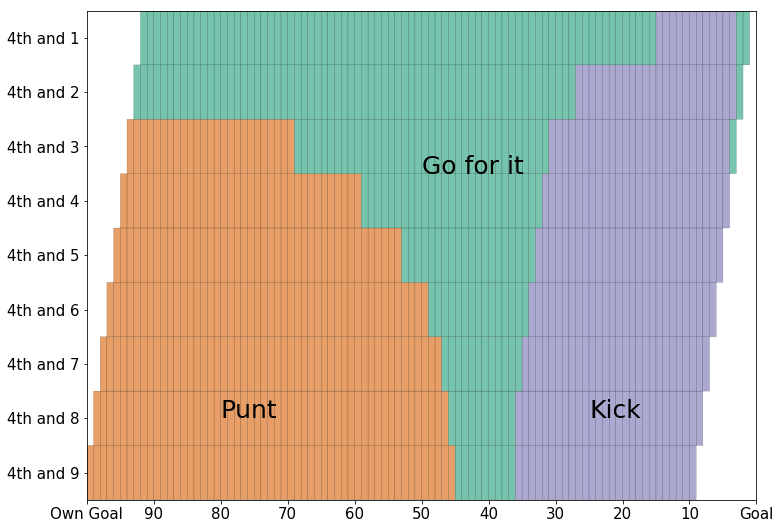

In [136]:
def build_decision_maker(yrdline100, ydstogo, ekv, epv_model, exp_conv_pct_model, 
                         exp_net_punt_dist_model, exp_fg_prob_model,
                        m_ekv, m_epv_model, m_exp_conv_pct_model, w, just_epvs=False):
    
    YRDSTOGO_CAP = 10  # Model restriction
    PUNT_LIM = 29      # Model restriction
    FG_LIM = 63        # Model restriction
    FG_OFFSET = 8      # Field goal placement distance (not including the 10 for the endzone)
    FG_FAIL_RESET = 0  # Where the ball is placed after a failed field goal.  If 0, at the spot.  
                       # Otherwise, at the spot or at the reset spot, whichever is better.
    if yrdline100 < 10:
        region = 'Inside10'
    elif yrdline100 < 20:
        region = '10to20'
    else:
        region = 'Beyond20'
            
        # 1. Expected value of going for it
        
        # Value of failing (approximately turning over at same spot)
    conv_fail_yrdline100 = 100 - yrdline100
    if conv_fail_yrdline100 >=100:
        conv_fail_yrdline100 = 99
    elif conv_fail_yrdline100 < 0:
        conv_fail_yrdline100 = 0
    conv_fail_epv = -epv_model[conv_fail_yrdline100] 
        
    m_conv_fail_epv = -m_epv_model[conv_fail_yrdline100]
        
        # Value of converting (approximately at the first down marker)
    if yrdline100 == ydstogo:
        conv_succ_epv = 6 - ekv
        m_conv_succ_epv = 6 - m_ekv
    else:
        first_down_yrdline100 = yrdline100 - ydstogo
        if first_down_yrdline100 <= 0:
            first_down_yrdline100 = 1
        elif first_down_yrdline100 > 99:
            first_down_yrdline100 = 99
        first_down_yrdline100 = int(first_down_yrdline100)
        conv_succ_epv = epv_model[first_down_yrdline100] - 1
        m_conv_succ_epv = m_epv_model[first_down_yrdline100] - 1

        # Conversion Pct
    exp_conv_pct = exp_conv_pct_model[(region, ydstogo)] if ydstogo < YRDSTOGO_CAP else None
    m_exp_conv_pct = m_exp_conv_pct_model[(region, ydstogo)] if ydstogo < YRDSTOGO_CAP else None
        
        # Overall expected value of going for it
    unmod_go_ev = exp_conv_pct * conv_succ_epv + (1 - exp_conv_pct) * conv_fail_epv
    m_go_ev = m_exp_conv_pct * m_conv_succ_epv + (1 - m_exp_conv_pct) * m_conv_fail_epv
    if just_epvs:
        return unmod_go_ev, m_go_ev
    go_ev = w * m_go_ev + (1 - w) * unmod_go_ev
        ####THIS IS WHERE YOU ADD THE MATCHUP EPV WEIGHT AND STUFF (ABOVE)
        
        
        
        
        # 2. Expected value of punting
        
        # Expected next yardline
    if yrdline100 >= PUNT_LIM:
        exp_net_punt_dist = exp_net_punt_dist_model[yrdline100]
        exp_yrdline100 = 100 - yrdline100 + int(exp_net_punt_dist)
            
            # Overall expected value of punting
        punt_ev = -epv_model[exp_yrdline100]
    else:
        punt_ev = None
            
        # 3. Expected value of kicking a field goal
    fg_dist =  yrdline100 + 10 + FG_OFFSET
    if fg_dist <= FG_LIM:
        # Probability of success
        exp_fg_prob = exp_fg_prob_model[fg_dist ]

        # Expected value of field success
        fg_succ_epv = 3 - ekv

        # EPV of field goal fail
        fg_fail_yrdline100 = 100 - yrdline100 - FG_OFFSET
        fg_fail_epv = -epv_model[fg_fail_yrdline100]

        # Overall expected value kicking
        fg_ev = fg_succ_epv * exp_fg_prob + fg_fail_epv * (1 - exp_fg_prob)
    else:
        fg_ev = None
    
    choices = [('go for it', go_ev), ('punt', punt_ev), ('kick', fg_ev)]
    max_val = -100
    for choice, ev in choices:
        if ev is None:
            continue
        if ev > max_val:
            max_val = ev
            decision = choice
    
    print_message=False
    if print_message:
        print("Expected Values")
        print("Go for it: {:.2f}".format(go_ev))
        if punt_ev is not None:
            print("Punt: {:.2f}".format(punt_ev))
        else:
            print("Punt: TOO CLOSE TO PUNT")
        if fg_ev is not None:
            print("FG: {:.2f}".format(fg_ev))
        else:
            print("FG: TOO FAR TO KICK")        

        print()
        print("Coach, you should:")
        print(decision.upper())
    
    return decision

# Build the decision maker

yrdlines = list(range(1, 100))
down_dist = list(range(1, 10))

decisions = []
for yrdstogo in down_dist:
    tmp = []
    for yrdline in yrdlines:
        if (yrdline >= yrdstogo) and (100 - yrdline + yrdstogo >= 10): # Exclude impossible scenarios
            decision = build_decision_maker(yrdline, yrdstogo, 
                                            ekv, epv_model, exp_conv_pct_model, exp_net_punt_dist_model, 
                                            exp_fg_prob_model, m_ekv, m_epv_model, m_exp_conv_pct_model, 0.05)
            tmp.append(decision)
        else:
            tmp.append(None)
    decisions.append(tmp)
# Convert to a table
pd.DataFrame(decisions, columns=yrdlines, index=down_dist)

import numpy as np
data = np.zeros((9, 99))
for i in range(9):
    for j in range(99):
        decision = decisions[i][j]
        if decision == 'go for it':
            val = 1
        elif decision == 'punt':
            val = 2
        elif decision == 'kick':
            val = 3
        elif decision is None:
            val = np.nan
        data[i, j] = val
data = data[::-1,::-1]

fig, ax = plt.subplots(figsize=(12, 9))

ax.pcolor(
    data,
    vmin=1,
    vmax=8,
    edgecolors='k', 
    linewidths=.2,
    cmap=plt.get_cmap('Dark2'),
    alpha=.6
);
ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax.set_xticklabels(['Own Goal', '90', '80', '70', '60', '50', '40', '30', '20', '10', 'Goal'])
ax.set_yticks([
    yd - .5
    for yd in range(1, 10)
])
ax.set_yticklabels([
    '4th and {}'.format(yd)
    for yd in range(9, 0, -1)
])
ax.text(50, 6, 'Go for it', size=25)
ax.text(20, 1.5, 'Punt', size=25)
ax.text(75, 1.5, 'Kick', size=25)
ax.tick_params(axis='both', which='major', labelsize=15);

In [138]:
avg_epv = [[0 for x in range(99)] for y in range(9)]
mod_epv = [[0 for x in range(99)] for y in range(9)]
for ydstogo in range(9):
    for yrdline100 in range (99):
        avg, mod = build_decision_maker(yrdline100, yrdstogo, 
                                            ekv, epv_model, exp_conv_pct_model, exp_net_punt_dist_model, 
                                            exp_fg_prob_model, m_ekv, m_epv_model, m_exp_conv_pct_model, 0.05, True)
        avg_epv[ydstogo][yrdline100] = avg
        mod_epv[ydstogo][yrdline100] = mod
        
np.savetxt('avg_epv.py', avg_epv, fmt='%s')
np.savetxt('mod_epv.py', mod_epv, fmt='%s')


In [ ]:
path = "Test_File.csv"
cols = ['gameId', 'driveIndex', 'year', 'week', 'clock', 'quarter', 'down', 'yardLine', 'distance', 'yardsGained',
            'offenseTeam', 'defenseTeam', 'description', 'type',
            'homeScore', 'awayScore', 'homeTeam', 'awayTeam']
df = pd.read_csv(path,index_col=None, header=0, usecols=cols)
df["home_off_away_def"] = np.repeat(True, len(df))
testpxp = cf.m_extract_data(df)
m_ko_and_poss = cf.modified_extract_k_and_p(testpxp)
m_third_downs = cf.extract_third_downs(testpxp)
m_ekv, m_epv_model = cf.epv_model(m_ko_and_poss)
m_exp_conv_pct_model = cf.exp_conv_pct_model(m_third_downs)
m_epv_model

In [ ]:
path = "Test_File.csv"
cols = ['gameId', 'driveIndex', 'year', 'week', 'clock', 'quarter', 'down', 'yardLine', 'distance', 'yardsGained',
            'offenseTeam', 'defenseTeam', 'description', 'type',
            'homeScore', 'awayScore', 'homeTeam', 'awayTeam']
df = pd.read_csv(path,index_col=None, header=0, usecols=cols)
testpxp = extract_data(df)
m_ko_and_poss = cf.extract_kickoffs_and_possessions(testpxp)
m_third_downs = cf.extract_third_downs(testpxp)
ekv, epv_model = cf.epv_model(m_ko_and_poss)
exp_conv_pct_model = cf.exp_conv_pct_model(m_third_downs)
epv_model

In [ ]:
def extract_data(pxp):

# We only cover offensive TouchDown

    cols = ['gameId', 'driveIndex', 'quarter', 'down', 'yardLine', 'distance', 'yardsGained',
            'offenseTeam', 'defenseTeam', 'description', 'type', 'isScoringPlay',
            'homeScore', 'awayScore', 'homeTeam', 'awayTeam', 'clock']

    pxp['type'].fillna('No Play', inplace = True)

    # Compute half.  For OT (qtr = 5 or 6), use half = 3. 
    pxp['half'] = pd.cut(pxp['quarter'], [1,2,4,6], labels=[1,2,3], include_lowest=True)

    # Compute yardage (NCAA data yardage is relative to home team except for kickoff plays) 
    pxp['yrdline100'] = np.select([(pxp['homeTeam'] == pxp['offenseTeam']) & (~pxp['type'].str.contains('Kickoff')), 
                                (pxp['homeTeam'] == pxp['offenseTeam']) & (pxp['type'].str.contains('Kickoff')), 
                                (pxp['awayTeam'] == pxp['offenseTeam']) & (~pxp['type'].str.contains('Kickoff')),
                                (pxp['awayTeam'] == pxp['offenseTeam']) & (pxp['type'].str.contains('Kickoff'))], 
                               [100-pxp['yardLine'], pxp['yardLine'], pxp['yardLine'], 100-pxp['yardLine']], default='np.nan')
    pxp['yrdline100'] = np.select([(pxp['homeTeam'] == pxp['offenseTeam']),
                                (pxp['awayTeam'] == pxp['offenseTeam'])], 
                               [100-pxp['yardLine'], pxp['yardLine']], default=None).astype(float)
    # Compute field region
    pxp['yrdregion'] = pd.cut(pxp['yrdline100'], [0., 9., 20., 100.], labels=['Inside10', '10to20', 'Beyond20'])
    
    # Compute Touchdown play: Make a new column to determine offensive touchdown (only either rushing or passing play)
    # The NFL model use both defensive and offensive TD here (and some other weird type of TD)
    pxp['Touchdown'] = np.where((pxp['type']=='Passing Touchdown')|(pxp['type']=='Rushing Touchdown')|(pxp['description'].str.contains('TD'))|(pxp['description'].str.contains('Touchdown'))|(pxp['description'].str.contains('TOUCHDOWN')), 1, 0)

    # index of play
    pxp['index'] = range(1, len(pxp) + 1)

    ## Compute fieldgoal play: Make a new column to determine fieldgoals as missed, blocked, or good
    fgcondition = [(pxp['type']=='Field Goal Good'), 
                (pxp['type']=='Field Goal Missed'),
                (pxp['type']=='Missed Field Goal Return'),
                (pxp['type']=='Missed Field Goal Return Touchdown'),
                (pxp['type']=='Blocked Field Goal'),
                (pxp['type']=='Blocked Field Goal Touchdown')]
    pxp['FieldGoalResult'] = np.select(fgcondition, ['Good', 'No Good', 'No Good', 'No Good', 'Blocked', 'Blocked'])
    pxp['FieldGoalResult'] = pxp['FieldGoalResult'].replace('0', np.nan)
    
    ## Compute fieldgoal distance: Make a new column to determine fieldgoals distance (blockFG for TD and return is different)
    pxp.loc[(pxp['type'].isin(['Field Goal Good','Field Goal Missed','Blocked Field Goal'])),'FieldGoalDistance']=pxp['yardsGained']
    pxp.loc[(pxp['type'].isin(['Missed Field Goal Return', 'Missed Field Goal Return Touchdown','Blocked Field Goal Touchdown'])),'FieldGoalDistance']=pxp['yrdline100']


    # Fill in missing values due to timeouts leaving NAs in the dataset. This is not needed in NCAA plays
#     pxp.loc[:, ['HomeScore', 'AwayScore']] = pxp[['HomeScore', 'AwayScore']].fillna(method='ffill')
    
    # Compute nextposteam, nextyrdline100, nextdown, and 1stdownconversion.  Must be within a game 
    # and a half since possession doesn't carry between halves and obviously not between games.  
    # Non-relevant plays are ignored so that computations aren't mangled.

#     There is no extra point plays
    ignore_plays = ['Penalty', 'End Period', 'Timeout', 'End of Half', 'End of Game', 
        'No Play', 'Coin Toss', 'Extra Point Good','Blocked PAT','Extra Point Missed']
    
    ignore_mask = ~pxp['type'].isin(ignore_plays)
    game_halves = pxp.\
        loc[ignore_mask].\
        groupby(['gameId', 'half'])
    pxp.loc[ignore_mask, 'nextposteam'] = game_halves['offenseTeam'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, 'nextyrdline100'] = game_halves['yrdline100'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, 'nextdown'] = game_halves['down'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, '1stdownconversion'] = (
        (pxp.loc[ignore_mask, 'nextdown'] == 1.) | 
        (pxp.loc[ignore_mask, 'distance'] <= pxp.loc[ignore_mask, 'yardsGained']) |
        (pxp.loc[ignore_mask, 'Touchdown'] == 1)
    ).astype(int)
    try:
        pxp['yrdline100'] = [int(x) for x in pxp['yrdline100']]
    except ValueError:
        do_nothing = 2
    return pxp